# The Boolean Pandemic

__Master Program DSAA    
Machine Learning 2020 - Group Project__

__Group:__

Alex Panchot [M20190546]  
Andreia Antunes [M20190876]  
Bruno Vieira [M20190922]  
Fernanda Zippinotti [M20190232]  
Leonardo Lannes [M20180036]  

__Project Description__  

On January 1st, 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000 people at the end of February, with a mortality rate of more than 50%.  
While the conditions of the transmission of the virus is still unknown and there are no certainties of what leads a patient to survive or not to the virus, it seems there are some groups of people more prone to survive than others.
In this challenge, your goal is to build a predictive model that answers the question “What are the people more likely to survive to the boolean pandemic?” using the small quantity of data accessible of the patients – name, birthday date, severity of the disease, money of expenses associated to the treatment of each family, city and others.
As data scientists, your team is asked to analyze and transform as needed the data available and apply different models in order to answer in the more accurate way the defined question. Are you able to design a model that can predict if a patient will survive, or not, to the boolean pandemic?

__`Data fields`__

- **Patient_ID** - The unique identifier of the patient  
- **Family_Case_ID** - The family identification  
- **Severity** - The severity of the disease, where 1 is the lowest and 3 the highest severity  
- **Name** - The name of the patient  
- **Birthday_year** - The year of birthday of the patient  
- **Parents_Siblings_Infected** - The number of parents and/or siblings infected  
- **Partner_Children_Infected** - The number of partner and/or children infected  
- **Medical_Expenses_Family** - The medical expenses associated to try to contain the epidemy on the family  
- **Medical_Tent** - The medical tent where the patient is / was lodged  
- **City** - The original city of the patient  
  

__`Target`__
- **Deceased** - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)  

## 1. Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
np.random.seed(15)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
import re
from collections import Counter

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC

from tqdm import tqdm

from xgboost import XGBClassifier

from pandas_profiling import ProfileReport
import category_encoders as ce

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## 2. Import data

In [2]:
#read train data from csv file
df_train = pd.read_csv(r'train.csv')

In [3]:
#let's have a look at first 5 records
df_train.head().transpose()

,0,1,2,3,4
Patient_ID,1,2,3,4,5
Family_Case_ID,4696,21436,7273,8226,19689
Severity,3,1,3,3,3
Name,Miss Linda Betty,Ms. Ramona Elvira,Mr. Mario Vernon,Mr. Hector Joe,Ms. Jennie Debra
Birthday_year,NaN,1966,1982,1997,1994
Parents or siblings infected,0,0,0,0,0
Wife/Husband or children infected,0,1,0,0,0
Medical_Expenses_Family,225,1663,221,220,222
Medical_Tent,NaN,NaN,NaN,NaN,NaN
City,Santa Fe,Albuquerque,Santa Fe,Santa Fe,Santa Fe


In [4]:
#read test data from csv file
df_test = pd.read_csv(r'test.csv')

In [5]:
#let's have a look at first 5 records
df_test.head().transpose()

,0,1,2,3,4
Patient_ID,901,902,903,904,905
Family_Case_ID,49242,10400,10795,62440,81311
Severity,3,3,3,3,2
Name,Mr. Jody Pedro,Mr. Kevin Brent,Mr. Frankie Cary,Mr. Rick Pete,Mr. Matthew Erick
Birthday_year,NaN,1988,1981,NaN,1996
Parents or siblings infected,0,0,1,0,0
Wife/Husband or children infected,0,0,0,1,0
Medical_Expenses_Family,203,631,376,405,378
Medical_Tent,NaN,NaN,NaN,NaN,NaN
City,Santa Fe,Santa Fe,Albuquerque,Albuquerque,Santa Fe


## 3. Data pre-processing

### 3.1. Data Understanding

In [6]:
# Summary statistics for all variables 
def summary(dataframe):
    summary=dataframe.describe(include='all') 
    summary=summary.transpose()
    return summary.head(len(summary))

In [7]:
summary(df_train)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Patient_ID,900,NaN,NaN,NaN,450.5,259.952,1,225.75,450.5,675.25,900
Family_Case_ID,900,NaN,NaN,NaN,14305.8,25418.2,345,8203,13593.5,18906.5,742836
Severity,900,NaN,NaN,NaN,2.31333,0.834223,1,2,3,3,3
Name,900,899,Mr. Samuel Darnell,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birthday_year,723,NaN,NaN,NaN,1990.27,14.5233,1940,1982,1992,1999.5,2019
Parents or siblings infected,900,NaN,NaN,NaN,0.38,0.803247,0,0,0,0,6
Wife/Husband or children infected,900,NaN,NaN,NaN,0.521111,1.09839,0,0,0,1,8
Medical_Expenses_Family,900,NaN,NaN,NaN,895.743,1385.83,0,221,405,861.25,14345
Medical_Tent,198,8,C,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,898,3,Santa Fe,649,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         400 non-null    int64  
 1   Family_Case_ID                     400 non-null    int64  
 2   Severity                           400 non-null    int64  
 3   Name                               400 non-null    object 
 4   Birthday_year                      318 non-null    float64
 5   Parents or siblings infected       400 non-null    int64  
 6   Wife/Husband or children infected  400 non-null    int64  
 7   Medical_Expenses_Family            400 non-null    int64  
 8   Medical_Tent                       89 non-null     object 
 9   City                               400 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 31.4+ KB


In [9]:
#variables with null vallues
df_train.isna().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [10]:
#variables with null vallues
df_test.isna().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                         82
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         311
City                                   0
dtype: int64

#### Comments:
- We have 900 records in train dataset and 400 records on test dataset.  
- Both datasets have the same information, with the exception of target value that is missing on test dataset.  
- There some null values:
    - Train: Birthday_year, Medical_tent and City
    - Test: Birthday_year and Medical_tent

In [11]:
# pandas profiling is a cool feature for exploratory data analysis. More information here: https://github.com/pandas-profiling/pandas-profiling
df_train_copy = df_train.copy(deep=True)
profile = ProfileReport(df_train_copy, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_widgets()

#### Comments:

- Birthday_year and Medical_Tent have the highest number of missing values (19.7% and 76.1% respectively)  
- We have 900 records and 0 duplicate rows  
- Variables Patient_ID, Family_Case_ID and Name are likely to be dropped or used for feature engineering  
- There are two records without City information, since Santa Fe is largely the most frequent city it seems reasonable to assume those two records as from Santa Fe.

__`Target variable - 'Deceased'`__

Let's have a look at the distribution of variables among deceased and survivors.

In [12]:
df_train.groupby(by="Deceased").mean().transpose()

Deceased,0,1
Patient_ID,449.423631,451.175407
Family_Case_ID,13619.536023,14736.466546
Severity,1.962536,2.533454
Birthday_year,1991.698305,1989.280374
Parents or siblings infected,0.463977,0.327306
Wife/Husband or children infected,0.475504,0.549729
Medical_Expenses_Family,1340.755043,616.504521


In [13]:
deceased_temp = df_train[df_train.Deceased == 1]
survived_temp = df_train[df_train.Deceased == 0]

Text(0, 0.5, 'Frequency')

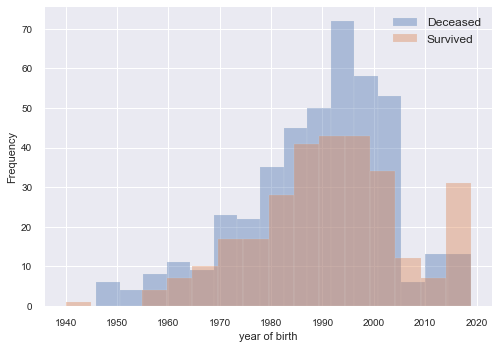

In [14]:
sns.distplot(deceased_temp['Birthday_year'], kde = False, label='Deceased')
sns.distplot(survived_temp['Birthday_year'], kde = False, label='Survived')

plt.legend(prop={'size': 12})
plt.xlabel('year of birth')
plt.ylabel('Frequency')

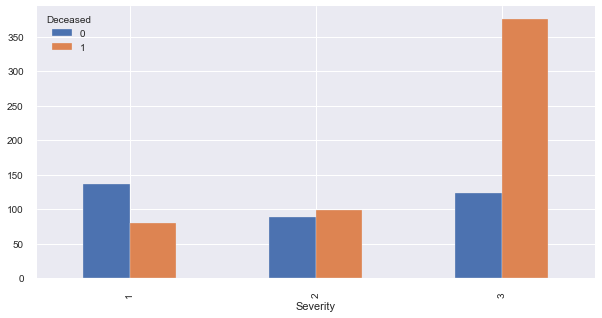

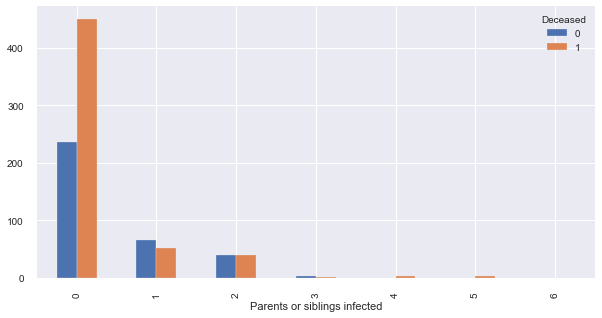

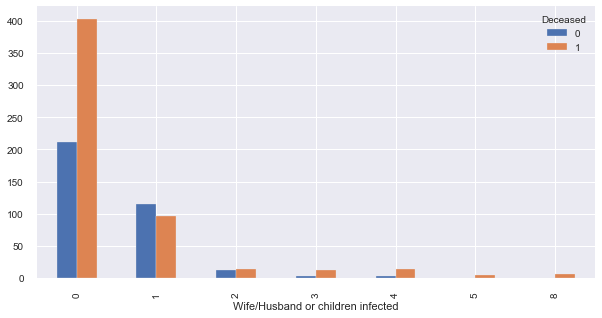

In [15]:
#let's have a look at some variables distribution per deceased
columns = ['Severity', 'Parents or siblings infected', 'Wife/Husband or children infected']

for col in columns:
    pd.crosstab(df_train[col],df_train.Deceased).plot(kind='bar',
                                          figsize=(10,5))

__`Medical Tent`__

In [16]:
def perc_table(index, columns, values):
    perc_table = pd.crosstab(index = index, 
                     columns = columns, 
                     values = values, 
                     aggfunc='count', margins = True,
                     normalize='columns').applymap('{:.3%}'.format)
    return perc_table

In [17]:
perc_table(df_train.Medical_Tent, df_train.City, df_train.index)

City,Albuquerque,Santa Fe,Taos,All
Medical_Tent,,,,
A,10.145%,6.504%,0.000%,7.653%
B,31.884%,17.886%,0.000%,22.449%
C,30.435%,27.642%,50.000%,29.082%
D,18.841%,14.634%,0.000%,15.816%
E,7.246%,20.325%,25.000%,15.816%
F,1.449%,8.943%,25.000%,6.633%
G,0.000%,3.252%,0.000%,2.041%
T,0.000%,0.813%,0.000%,0.510%


#### Comments:
From the table above we can observe that there are no rules we can establish for the Medical tents locations that could help us populate the missing values.  
Since we don't have enough information we have two possibilities:
- drop the column,
- fill missing values with No_tent.

__`Name`__

In [18]:
print(df_train.Name.str.split(' ').str[0].unique())

['Miss' 'Ms.' 'Mr.' 'Master']


In [19]:
print(df_test.Name.str.split(' ').str[0].unique())

['Mr.' 'Mrs.' 'Miss' 'Master']


#### Comments:
All records have name filled in and all start by either 'Miss', 'Ms.', 'Mrs.', 'Mr.' or 'Master. This information is quite useful to generate a new field **Gender**.

### 3.2. Data Preparation

In [20]:
X = df_train.drop('Deceased', axis = 1)
y = df_train['Deceased']

In [21]:
df_test_copy = df_test.copy(deep=True)

### 3.2.1. Missing values

Let's fill in the missing values as being 'No tent'.

In [22]:
# fill in medical tent 
X['Medical_Tent'].fillna('No_tent', inplace = True)

In [23]:
df_test_copy['Medical_Tent'].fillna('No_tent', inplace = True)

For Birthday_year, we will fill in missing values with the mean value for the entire dataset, using SimpleImputer.

In [24]:
#Fill in birthday year

imputer = SimpleImputer(strategy='mean').fit(X.loc[:,['Birthday_year']])

X.loc[:,'Birthday_year'] = imputer.transform(X.loc[:,['Birthday_year']]).astype(int)

We also fill in the missing values in test set using the fitted imputer from Train set.

In [25]:
df_test_copy.loc[:,'Birthday_year'] = imputer.transform(df_test_copy.loc[:,['Birthday_year']]).astype(int)

Since 'Santa Fe' is the most frequent City, with more than 72%, we decided to fill the 2 missing values in the train set as being from 'Santa Fe'. 

In [26]:
#Fill in city

X['City'].fillna('Santa Fe', inplace = True)

### 3.2.2. Feature Engineering

__`Gender`__

In [27]:
gender_dict ={'Miss' : 'F', 'Ms.' : 'F', 'Mrs.':'F', 
                    'Mr.' : 'M', 'Master' : 'M'} 

X['Gender'] = X.Name.str.split(' ').str[0].map(gender_dict) 

In [28]:
df_test_copy['Gender'] = df_test_copy.Name.str.split(' ').str[0].map(gender_dict) 

__`Expenses per person (pp)`__

To have a comparable expense feature we decided to compute the medical expenses per person:

In [29]:
X['Expenses_pp'] = X['Medical_Expenses_Family'] / (X['Parents or siblings infected'] + X['Wife/Husband or children infected'] + 1)


In [30]:
df_test_copy['Expenses_pp'] = df_test_copy['Medical_Expenses_Family'] / (df_test_copy['Parents or siblings infected'] + df_test_copy['Wife/Husband or children infected'] + 1)

In [31]:
#let's drop the family medical expenses, since we don't longer need it
X.drop('Medical_Expenses_Family', axis = 1, inplace=True)

In [32]:
df_test_copy.drop('Medical_Expenses_Family', axis = 1, inplace=True)

__`Family Avg Severity`__

We thought it might be interesting to have a feature that showed how the disease affected the family.

In [33]:
total_db = X.append(df_test)
total_db = total_db[['Family_Case_ID','Severity']] .groupby(by='Family_Case_ID').mean()

In [34]:
X['family_severity'] = X.merge(total_db, how='left', left_on ='Family_Case_ID', right_on = 'Family_Case_ID')['Severity_y']

In [35]:
X['family_severity'] = X['family_severity'].fillna(0)

In [36]:
df_test_copy['family_severity'] = df_test_copy.merge(total_db, how='left', left_on ='Family_Case_ID', right_on = 'Family_Case_ID')['Severity_y']

In [37]:
df_test_copy['family_severity']= df_test_copy['family_severity'].fillna(0)

__`Encoding`__

In [38]:
# Encode categorical variables to dummy variables
cat_features=['Medical_Tent', 'City', 'Gender']

ce_one_hot = ce.OneHotEncoder(cols = cat_features, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [39]:
df_test_copy = ce_one_hot.fit_transform(df_test_copy)

__`Drop Columns`__

In [40]:
cols_drop = ['Patient_ID','Family_Case_ID','Name', 
             'Medical_Tent_T', 'City_Taos','Gender_M']

In [41]:
X.drop(columns = cols_drop, inplace = True)
df_test_copy.drop(columns = ['Patient_ID','Family_Case_ID','Name', 'City_Taos','Gender_M'], inplace = True)

__`Ordering Columns`__

Let's order the columns on test set to be equal to the train set, this will be fundamental later on for some models we want to test.

In [42]:
cols_order = ['Severity','Birthday_year',
              'Parents or siblings infected',
              'Wife/Husband or children infected',
              'Medical_Tent_No_tent','Medical_Tent_F','Medical_Tent_B',
              'Medical_Tent_A', 'Medical_Tent_E','Medical_Tent_C',
              'Medical_Tent_D','Medical_Tent_G','City_Santa Fe','City_Albuquerque',
              'Gender_F','Expenses_pp','family_severity']

In [43]:
df_test_copy = df_test_copy[cols_order]

### 3.3. Train test split

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2, 
                                                  stratify = y,
                                                  random_state = 0)

### 3.4 Feature Selection

#### 3.4.1 Extra Trees Classifier
- Trees classifiers works as n decision trees (in this case 50), the good thing about this is the possibility to plot and make sense of what is going on
- And the feature_selection algorithm select the features that are relevant.

In [45]:
#from pratical classes

def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()


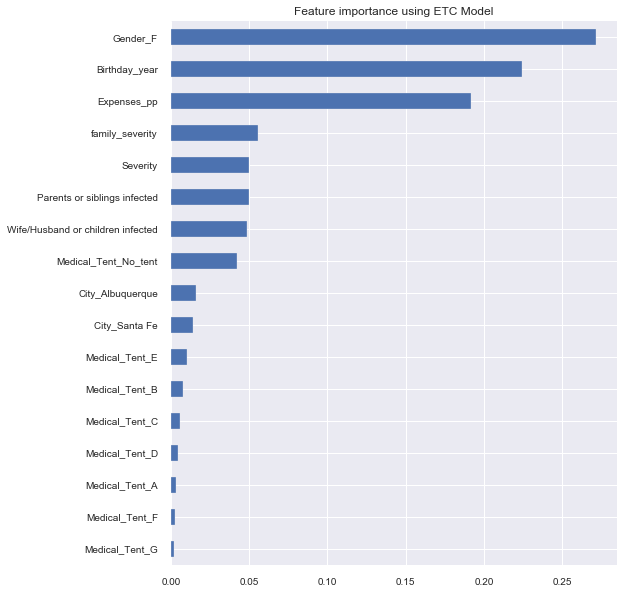

Medical_Tent_G                       0.001876
Medical_Tent_F                       0.002709
Medical_Tent_A                       0.003133
Medical_Tent_D                       0.004627
Medical_Tent_C                       0.005827
Medical_Tent_B                       0.007535
Medical_Tent_E                       0.010259
City_Santa Fe                        0.014099
City_Albuquerque                     0.016018
Medical_Tent_No_tent                 0.042415
Wife/Husband or children infected    0.048460
Parents or siblings infected         0.049875
Severity                             0.049969
family_severity                      0.055672
Expenses_pp                          0.191559
Birthday_year                        0.224273
Gender_F                             0.271693
dtype: float64

In [47]:
ETC = ExtraTreesClassifier(n_estimators=50, random_state = 0)
ETC = ETC.fit(X_train, y_train)
coef_ETC = pd.Series(ETC.feature_importances_, index = X_train.columns)
plot_importance(coef_ETC,'ETC')
coef_ETC.abs().sort_values()  

In [48]:
model = SelectFromModel(ETC, prefit=True)
model.transform(X_train)
ETC_indices = model.get_support(indices= True)
ETC_feature = X_train.iloc[:,ETC_indices].columns
ETC_feature

Index(['Birthday_year', 'Gender_F', 'Expenses_pp'], dtype='object')

#### 3.4.2. Correlation

In [49]:
def cor_heatmap(cor):
    mask = np.triu(np.ones_like(cor, dtype=bool))
    plt.figure(figsize=(14,12))
    sns.set(font_scale=1.4, style = 'white')
    sns.heatmap(data = cor, annot = True, annot_kws={"size": 10},
                mask = mask, cmap = plt.cm.Reds, fmt='.1f')
    plt.show()

In [50]:
temp_X = X_train.copy(deep=True)
temp_X['target'] = y_train

In [51]:
corr_spearman = temp_X.corr('spearman')

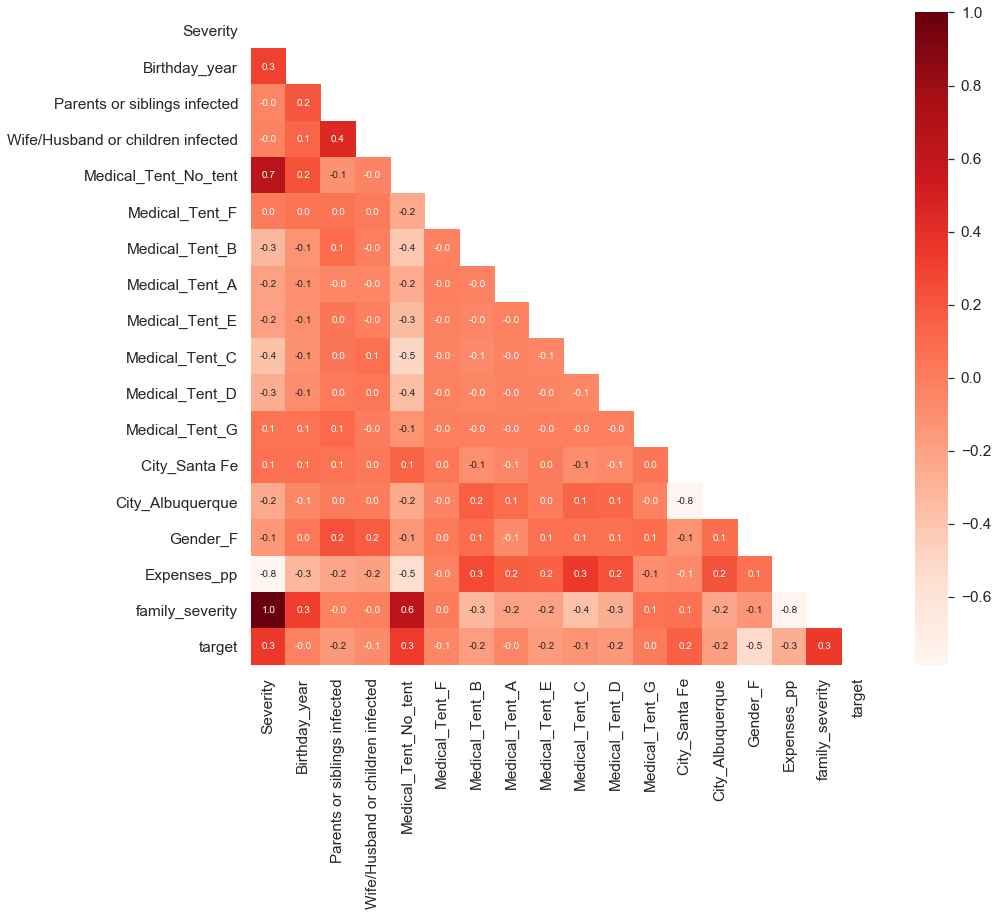

In [52]:
cor_heatmap(corr_spearman)

#### 3.4.3. Lasso

In [53]:
lasso = LassoCV()
lasso.fit(X = X_train, y = y_train)
print("Best alpha using built-in LassoCV: %f" % lasso.alpha_)

Best alpha using built-in LassoCV: 0.120299


In [54]:
coef_lasso = pd.Series(lasso.coef_,index=X.columns)
coef_lasso

Severity                             0.000000
Birthday_year                       -0.002678
Parents or siblings infected        -0.000000
Wife/Husband or children infected    0.000000
Medical_Tent_No_tent                 0.000000
Medical_Tent_F                      -0.000000
Medical_Tent_B                      -0.000000
Medical_Tent_A                      -0.000000
Medical_Tent_E                      -0.000000
Medical_Tent_C                      -0.000000
Medical_Tent_D                      -0.000000
Medical_Tent_G                       0.000000
City_Santa Fe                        0.000000
City_Albuquerque                    -0.000000
Gender_F                            -0.000000
Expenses_pp                         -0.000107
family_severity                      0.000000
dtype: float64

In [55]:
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso == 0)) + " variables")

Lasso picked 2 variables and eliminated the other 15 variables


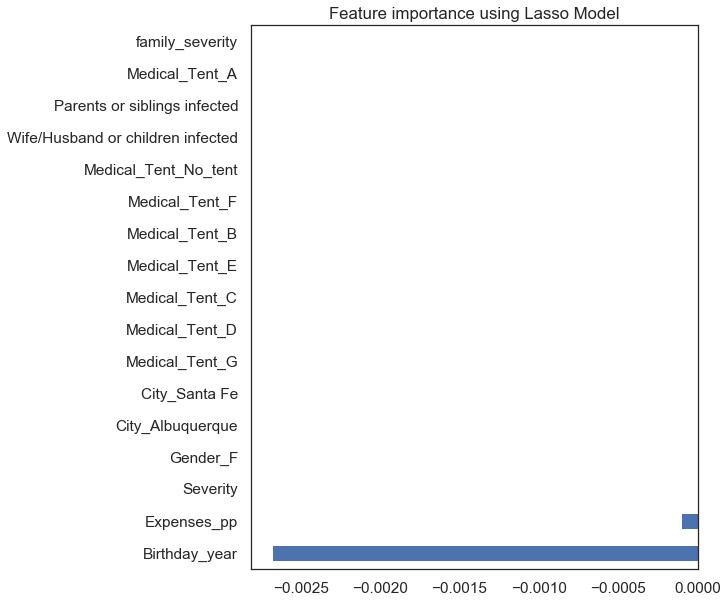

In [56]:
plot_importance(coef_lasso,'Lasso')

In [57]:
# Extracting important features according to Lasso Regression

lasso_features = coef_lasso.sort_values().abs() > 0
lasso_features = lasso_features[lasso_features].index.values
lasso_features

array(['Birthday_year', 'Expenses_pp'], dtype=object)

#### 3.4.4. RFE_CV

In [58]:
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)

rfecv = RFECV(rf_clf, cv= 5, step=1)
rfecv = rfecv.fit(X_train, y_train)

rfecv_mask = rfecv.get_support() 

rfecv_features = [] 

for bool, feature in zip(rfecv_mask, X_train.columns):
    if bool:
        rfecv_features.append(feature)
        
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', rfecv_features)

Optimal number of features : 16
Best features : ['Severity', 'Birthday_year', 'Parents or siblings infected', 'Wife/Husband or children infected', 'Medical_Tent_No_tent', 'Medical_Tent_F', 'Medical_Tent_B', 'Medical_Tent_A', 'Medical_Tent_E', 'Medical_Tent_C', 'Medical_Tent_D', 'City_Santa Fe', 'City_Albuquerque', 'Gender_F', 'Expenses_pp', 'family_severity']


In [59]:
coef_rfecv = pd.Series(rf_clf.feature_importances_,index=X.columns).abs().sort_values()
coef_rfecv


Medical_Tent_G                       0.002323
Medical_Tent_F                       0.002778
Medical_Tent_A                       0.002861
Medical_Tent_D                       0.006648
Medical_Tent_B                       0.007116
Medical_Tent_C                       0.007397
Medical_Tent_E                       0.008908
City_Albuquerque                     0.015196
City_Santa Fe                        0.019693
Medical_Tent_No_tent                 0.037572
Parents or siblings infected         0.038863
Wife/Husband or children infected    0.043274
Severity                             0.048292
family_severity                      0.050400
Expenses_pp                          0.219103
Birthday_year                        0.237459
Gender_F                             0.252115
dtype: float64

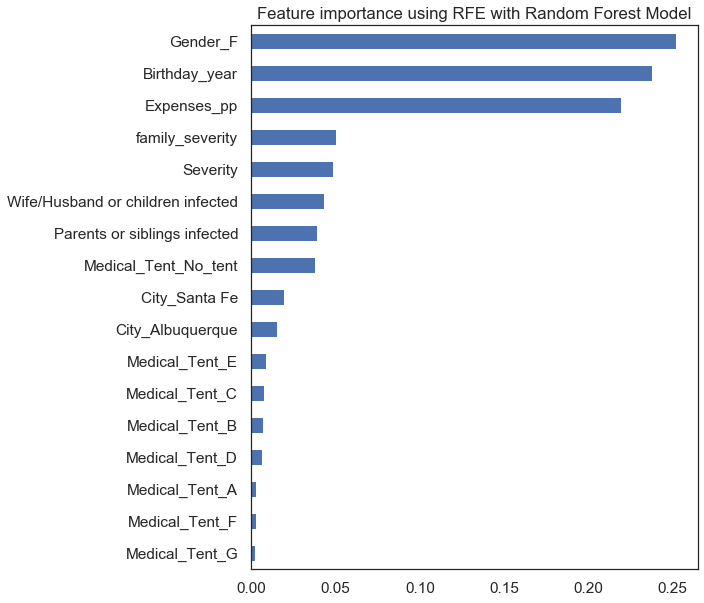

In [60]:
plot_importance(coef_rfecv,'RFE with Random Forest')

#### 3.4.5 Selected Features

In [61]:
#Get the repeated features for the 3 criteria
feat_freq = pd.Series(np.concatenate([ ETC_feature, rfecv_features, lasso_features])).value_counts()
feat_freq          

Expenses_pp                          3
Birthday_year                        3
Gender_F                             2
Parents or siblings infected         1
City_Albuquerque                     1
Medical_Tent_F                       1
family_severity                      1
Medical_Tent_B                       1
Medical_Tent_No_tent                 1
Medical_Tent_D                       1
Medical_Tent_E                       1
Medical_Tent_C                       1
City_Santa Fe                        1
Medical_Tent_A                       1
Severity                             1
Wife/Husband or children infected    1
dtype: int64

In [62]:
# Get features that fulfil more than 2 criteria
features = feat_freq[feat_freq >= 1].index.tolist()
features

['Expenses_pp',
 'Birthday_year',
 'Gender_F',
 'Parents or siblings infected',
 'City_Albuquerque',
 'Medical_Tent_F',
 'family_severity',
 'Medical_Tent_B',
 'Medical_Tent_No_tent',
 'Medical_Tent_D',
 'Medical_Tent_E',
 'Medical_Tent_C',
 'City_Santa Fe',
 'Medical_Tent_A',
 'Severity',
 'Wife/Husband or children infected']

**Comments:**

The chosen algorithms to do a feature selection are greedy and may describe a feature as non-relevant even though that feature along with others increase the model accuracy.
In the following section we used this information to run different model combinations and we reached the conclusion that our best performing model included all features, excluding the family severity feature.

In [63]:
cols_drop = ['family_severity']

In [64]:
X.drop(columns = cols_drop, inplace = True)
df_test_copy.drop(columns = cols_drop, inplace = True)

### 3.5. Scaling Features

We tried 5 different scalers with the XGBoost gridsearch and the MinMaxScaler was the best. It makes sense as the best as it scales all the features so the relative distances between values remains the same. It also does not affect the dummy variables that are representing the categorical variables.

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2, 
                                                  stratify = y,
                                                  random_state = 0)

In [66]:
scaler = MinMaxScaler()
columns = X.columns

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = columns

X_val = pd.DataFrame(scaler.transform(X_val))
X_val.columns = columns

scaler = MinMaxScaler()
columns = X.columns

X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = columns

df_test_copy = pd.DataFrame(scaler.transform(df_test_copy))
df_test_copy.columns = columns

## 4. Modeling

### Model A - XGBoost

In [67]:
mod_A_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier',
     BaggingClassifier(base_estimator=XGBClassifier(colsample_bytree=1.0,
                                                    eta=0.63,
                                                    max_depth=2),
                       n_estimators=10,
                       max_features=1.0,
                       bootstrap=True,
                       random_state=0))
])

In [68]:
mod_A_param_grid = {
    'scaler': [
        MinMaxScaler(),
        MinMaxScaler(feature_range=(-1, 1)),
        RobustScaler(),
        StandardScaler(),
        PowerTransformer()
    ],
    'classifier__n_estimators':list(np.arange(5, 15, 1)),  # Best: 9
    'classifier__max_features':list(np.arange(7, 9, 1)),  # Best: 8
    'classifier__bootstrap': [False],
}

In [69]:
#to be able to excatly reproduce the values we want to fix the seed, thus we initiate the Kfold for the GridSearch separetly and as follow:
kfold = KFold(n_splits = 5, random_state = 0)

In [70]:
mod_A_clf = GridSearchCV(mod_A_pipe,
                         mod_A_param_grid,
                         cv=kfold,
                         verbose=2,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring='accuracy')

In [71]:
mod_A = mod_A_clf.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   32.1s finished


In [72]:
mod_A.best_params_

{'classifier__bootstrap': False,
 'classifier__max_features': 8,
 'classifier__n_estimators': 14,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}

In [73]:
print('Mean: ', mod_A.cv_results_['mean_test_score'][mod_A.best_index_])
print('Split 1: ', mod_A.cv_results_['split0_test_score'][mod_A.best_index_])
print('Split 2: ', mod_A.cv_results_['split1_test_score'][mod_A.best_index_])
print('Split 3: ', mod_A.cv_results_['split2_test_score'][mod_A.best_index_])
print('Split 4: ', mod_A.cv_results_['split3_test_score'][mod_A.best_index_])
print('Split 5: ', mod_A.cv_results_['split4_test_score'][mod_A.best_index_])

Mean:  0.7877777777777778
Split 1:  0.8222222222222222
Split 2:  0.7888888888888889
Split 3:  0.7444444444444445
Split 4:  0.8222222222222222
Split 5:  0.7611111111111111


In [74]:
#let's get the score for the train and validation sets
score_train_mod_A = mod_A.score(X_train, y_train)
score_val_mod_A = mod_A.score(X_val, y_val)

In [75]:
score_train_mod_A

0.6138888888888889

In [76]:
#save results to show in dataframe
models_list = ['Model_A_XGBoost']
train_list = [np.round(score_train_mod_A, 4)]
validation_list = [np.round(score_val_mod_A, 4)]

### Model B.1 - Decision Tree

Firstly we are going to select a alpha value to be use on other models based on Decision Tree

In [78]:
mod_B1_param_grid = {
    'ccp_alpha': list(np.linspace(0, 0.12, 25)),
    'random_state': [0]
}
mod_B1 = DecisionTreeClassifier(random_state = 0)

mod_B1_clf = GridSearchCV(mod_B1,
                          mod_B1_param_grid,
                          n_jobs = -1,
                          verbose = 5,
                          cv = kfold)

mod_B1_clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 out of 125 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02,

In [79]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', mod_B1_clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = mod_B1_clf.cv_results_['mean_test_score']
stds = mod_B1_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mod_B1_clf.cv_results_['params']):
    if mean>.81:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'ccp_alpha': 0.005, 'random_state': 0}
------------------------------------------------------------------------------------------------------------------------


In [80]:
#let's get the score for the train and validation sets
score_train_mod_B1 = mod_B1_clf.score(X_train, y_train)
score_val_mod_B1 = mod_B1_clf.score(X_val, y_val)

In [81]:
#save results to show in dataframe
models_list.append('Model_B1_DecisionTree')
train_list.append(np.round(score_train_mod_B1,4))
validation_list.append(np.round(score_val_mod_B1,4))

### Model B.2 - AdaBoost

In [82]:
mod_B2_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [1.0, 0.9, 0.8],
    'algorithm': ['SAMME.R']
}

mod_B2 = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(ccp_alpha=0.005, random_state=0))

mod_B2_clf = GridSearchCV(mod_B2,
                          mod_B2_param_grid,
                          n_jobs=-1,
                          verbose=5,
                          cv=kfold)
mod_B2_clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:    3.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.005,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                       

In [83]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', mod_B2_clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = mod_B2_clf.cv_results_['mean_test_score']
stds = mod_B2_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mod_B2_clf.cv_results_['params']):
    if mean>.76:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'algorithm': 'SAMME.R', 'learning_rate': 0.9, 'n_estimators': 250}
------------------------------------------------------------------------------------------------------------------------
0.761 (+/-0.039) for {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 250}
0.767 (+/-0.020) for {'algorithm': 'SAMME.R', 'learning_rate': 0.9, 'n_estimators': 100}
0.768 (+/-0.021) for {'algorithm': 'SAMME.R', 'learning_rate': 0.9, 'n_estimators': 150}
0.767 (+/-0.019) for {'algorithm': 'SAMME.R', 'learning_rate': 0.9, 'n_estimators': 200}
0.769 (+/-0.020) for {'algorithm': 'SAMME.R', 'learning_rate': 0.9, 'n_estimators': 250}
0.761 (+/-0.030) for {'algorithm': 'SAMME.R', 'learning_rate': 0.8, 'n_estimators': 200}


In [84]:
mod_B2_clf.score(X_val,y_val)

0.7888888888888889

In [85]:
#let's get the score for the train and validation sets
score_train_mod_B2 = mod_B2_clf.score(X_train, y_train)
score_val_mod_B2 = mod_B2_clf.score(X_val, y_val)

In [86]:
#save results to show in dataframe
models_list.append('Model_B2_AdaBoost')
train_list.append(np.round(score_train_mod_B2,4))
validation_list.append(np.round(score_val_mod_B2,4))

### Model B.3 - GradientBoost

In [87]:
mod_B3_param_grid = {
    'loss': ['exponential'],
    'n_estimators': [60],
    'max_depth': [7, 9, 11, 13],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_features': [None]
}
mod_B3 = GradientBoostingClassifier(ccp_alpha=0.005, random_state=0)

mod_B3_clf = GridSearchCV(mod_B3,
                          mod_B3_param_grid,
                          n_jobs=-1,
                          verbose=5,
                          cv=kfold)
mod_B3_clf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.005,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight...
                                                  presort='deprecated',
                                

In [88]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', mod_B3_clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = mod_B3_clf.cv_results_['mean_test_score']
stds = mod_B3_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mod_B3_clf.cv_results_['params']):
    if mean>.8:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'loss': 'exponential', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 60}
------------------------------------------------------------------------------------------------------------------------
0.806 (+/-0.026) for {'loss': 'exponential', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 60}
0.807 (+/-0.021) for {'loss': 'exponential', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 20, 'n_estimators': 60}
0.811 (+/-0.022) for {'loss': 'exponential', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 60}
0.808 (+/-0.022) for {'loss': 'exponential', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 20, 'n_estimators': 60}
0.810 (+/-0.017) for {'loss': 'exponential', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 10, 'n_estimator

In [89]:
mod_B3_clf.score(X_val,y_val)

0.8444444444444444

In [90]:
#let's get the score for the train and validation sets
score_train_mod_B3 = mod_B3_clf.score(X_train, y_train)
score_val_mod_B3 = mod_B3_clf.score(X_val, y_val)

In [91]:
#save results to show in dataframe
models_list.append('Model_B3_GradientBoost')
train_list.append(np.round(score_train_mod_B3,4))
validation_list.append(np.round(score_val_mod_B3,4))

### Model B.4 - Random Forest

In [92]:
mod_B4_param_grid = {
    'n_estimators': [60, 80, 100, 120],
    'criterion': ['entropy'],
    'max_depth': [7, 9, 11],
    'oob_score': [True],
    'bootstrap': [True],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt']
}
mod_B4 = RandomForestClassifier(ccp_alpha=0.005, random_state=0)
mod_B4_clf = GridSearchCV(mod_B4,
                          mod_B4_param_grid,
                          n_jobs=-1,
                          verbose=5,
                          cv=kfold)
mod_B4_clf.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.005,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_...
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_sta

In [93]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', mod_B4_clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = mod_B4_clf.cv_results_['mean_test_score']
stds = mod_B4_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mod_B4_clf.cv_results_['params']):
    if mean>.84:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 120, 'oob_score': True}
------------------------------------------------------------------------------------------------------------------------


In [94]:
mod_B4_clf.score(X_val,y_val)

0.8222222222222222

In [95]:
#let's get the score for the train and validation sets
score_train_mod_B4 = mod_B4_clf.score(X_train, y_train)
score_val_mod_B4 = mod_B4_clf.score(X_val, y_val)

In [96]:
#save results to show in dataframe
models_list.append('Model_B4_RandomForest')
train_list.append(np.round(score_train_mod_B4,4))
validation_list.append(np.round(score_val_mod_B4,4))

### Model C - Neural Network

In [97]:
mod_C_param_grid = {
    'hidden_layer_sizes': [(16, 16), (8, 8), (12, 12), (16, 8)],
    'activation': ['relu'],
    'solver': ['lbfgs'],
    'max_iter': [50, 75, 100, 125, 150, 175, 200],
    'learning_rate': ['constant'],
}
mod_C = MLPClassifier(random_state=0)
mod_C_clf = GridSearchCV(mod_C,
                         mod_C_param_grid,
                         n_jobs=-1,
                         verbose=5,
                         cv=kfold)
mod_C_clf.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 117 out of 140 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nes...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['relu'],
                  

In [98]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', mod_C_clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = mod_C_clf.cv_results_['mean_test_score']
stds = mod_C_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mod_C_clf.cv_results_['params']):
    if mean>.811:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'activation': 'relu', 'hidden_layer_sizes': (16, 8), 'learning_rate': 'constant', 'max_iter': 75, 'solver': 'lbfgs'}
------------------------------------------------------------------------------------------------------------------------
0.811 (+/-0.028) for {'activation': 'relu', 'hidden_layer_sizes': (16, 8), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'lbfgs'}
0.817 (+/-0.029) for {'activation': 'relu', 'hidden_layer_sizes': (16, 8), 'learning_rate': 'constant', 'max_iter': 75, 'solver': 'lbfgs'}


In [99]:
mod_C_clf.score(X_val,y_val)

0.8

In [100]:
#let's get the score for the train and validation sets
score_train_mod_C = mod_C_clf.score(X_train, y_train)
score_val_mod_C = mod_C_clf.score(X_val, y_val)

In [101]:
#save results to show in dataframe
models_list.append('Model_C_NN_sklearn')
train_list.append(np.round(score_train_mod_C,4))
validation_list.append(np.round(score_val_mod_C,4))

### Model D - Neural Network with Keras

In [102]:
def build_classifier():

    classifier = Sequential()
    classifier.add(
        Dense(units=10,
              kernel_initializer='uniform',
              activation='relu',
              input_dim=X_train.shape[1]))
    classifier.add(Dropout(rate=0.1))
    classifier.add(
        Dense(units=10, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dropout(rate=0.1))
    classifier.add(
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

    classifier.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    return classifier

In [103]:
mod_D = KerasClassifier(build_fn=build_classifier, 
                        batch_size=10, epochs=100)

accuracies = cross_val_score(estimator=mod_D,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             n_jobs=-1)

In [104]:
mod_D_param_grid = {'batch_size': [25, 32], 'epochs': [10, 50, 100]}

mod_D_clf = GridSearchCV(estimator=mod_D,
                         param_grid=mod_D_param_grid,
                         scoring='accuracy',
                         cv=kfold)

mod_D_clf.fit(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
576/576 [==============================] - 0s 367us/step - loss: 0.6910 - accuracy: 0.6076
Epoch 2/10
576/576 [==============================] - 0s 39us/step - loss: 0.6868 - accuracy: 0.6181
Epoch 3/10
576/576 [==============================] - 0s 50us/step - loss: 0.6811 - accuracy: 0.6181
Epoch 4/10
576/576 [==============================] - 0s 45us/step - loss: 0.6734 - accuracy: 0.6181
Epoch 5/10
576/576 [==============================] - 0s 46us/step - loss: 0.6653 - accuracy: 0.6181
Epoch 6/10
576/576 [==============================] - 0s 46us/step - loss: 0.6549 - accuracy: 0.6181
Epoch 7/10
576/576 [==============================] - 0s 43us/step - loss: 0.6406 - accuracy: 0.6441
Epoch 8/10
576/576 [==============================] - 0s 42us/step - loss: 0.6295 - accuracy: 0.6580
Epoch 9/10
576/576 [==============================] - 0s 40us/step - lo

Epoch 26/50
576/576 [==============================] - 0s 39us/step - loss: 0.4909 - accuracy: 0.7847
Epoch 27/50
576/576 [==============================] - 0s 38us/step - loss: 0.4808 - accuracy: 0.7743
Epoch 28/50
576/576 [==============================] - 0s 36us/step - loss: 0.4891 - accuracy: 0.7743
Epoch 29/50
576/576 [==============================] - 0s 39us/step - loss: 0.4873 - accuracy: 0.7847
Epoch 30/50
576/576 [==============================] - 0s 39us/step - loss: 0.4895 - accuracy: 0.7812
Epoch 31/50
576/576 [==============================] - 0s 36us/step - loss: 0.4811 - accuracy: 0.7847
Epoch 32/50
576/576 [==============================] - 0s 37us/step - loss: 0.4801 - accuracy: 0.7899
Epoch 33/50
576/576 [==============================] - 0s 38us/step - loss: 0.4830 - accuracy: 0.7743
Epoch 34/50
576/576 [==============================] - 0s 41us/step - loss: 0.4854 - accuracy: 0.7830
Epoch 35/50
576/576 [==============================] - 0s 37us/step - loss: 0.4784

576/576 [==============================] - 0s 42us/step - loss: 0.6272 - accuracy: 0.6059
Epoch 7/50
576/576 [==============================] - 0s 42us/step - loss: 0.6151 - accuracy: 0.6059
Epoch 8/50
576/576 [==============================] - 0s 44us/step - loss: 0.6025 - accuracy: 0.6059
Epoch 9/50
576/576 [==============================] - 0s 42us/step - loss: 0.5924 - accuracy: 0.6059
Epoch 10/50
576/576 [==============================] - 0s 44us/step - loss: 0.5832 - accuracy: 0.6059
Epoch 11/50
576/576 [==============================] - 0s 42us/step - loss: 0.5760 - accuracy: 0.6806
Epoch 12/50
576/576 [==============================] - 0s 40us/step - loss: 0.5709 - accuracy: 0.7135
Epoch 13/50
576/576 [==============================] - 0s 39us/step - loss: 0.5554 - accuracy: 0.7413
Epoch 14/50
576/576 [==============================] - 0s 40us/step - loss: 0.5522 - accuracy: 0.7431
Epoch 15/50
576/576 [==============================] - 0s 37us/step - loss: 0.5438 - accuracy: 0.

576/576 [==============================] - 0s 40us/step - loss: 0.4526 - accuracy: 0.8038
Epoch 37/50
576/576 [==============================] - 0s 40us/step - loss: 0.4476 - accuracy: 0.7986
Epoch 38/50
576/576 [==============================] - 0s 37us/step - loss: 0.4437 - accuracy: 0.8038
Epoch 39/50
576/576 [==============================] - 0s 40us/step - loss: 0.4629 - accuracy: 0.7951
Epoch 40/50
576/576 [==============================] - 0s 39us/step - loss: 0.4496 - accuracy: 0.8038
Epoch 41/50
576/576 [==============================] - 0s 41us/step - loss: 0.4632 - accuracy: 0.8003
Epoch 42/50
576/576 [==============================] - 0s 41us/step - loss: 0.4351 - accuracy: 0.8073
Epoch 43/50
576/576 [==============================] - 0s 41us/step - loss: 0.4579 - accuracy: 0.7986
Epoch 44/50
576/576 [==============================] - 0s 39us/step - loss: 0.4439 - accuracy: 0.8003
Epoch 45/50
576/576 [==============================] - 0s 38us/step - loss: 0.4340 - accuracy:

576/576 [==============================] - 0s 47us/step - loss: 0.5154 - accuracy: 0.7778
Epoch 17/100
576/576 [==============================] - 0s 48us/step - loss: 0.4990 - accuracy: 0.7760
Epoch 18/100
576/576 [==============================] - 0s 52us/step - loss: 0.5057 - accuracy: 0.7847
Epoch 19/100
576/576 [==============================] - 0s 48us/step - loss: 0.4905 - accuracy: 0.7778
Epoch 20/100
576/576 [==============================] - 0s 48us/step - loss: 0.4768 - accuracy: 0.7882
Epoch 21/100
576/576 [==============================] - 0s 49us/step - loss: 0.4791 - accuracy: 0.7934
Epoch 22/100
576/576 [==============================] - 0s 51us/step - loss: 0.4786 - accuracy: 0.7743
Epoch 23/100
576/576 [==============================] - 0s 54us/step - loss: 0.4836 - accuracy: 0.7726
Epoch 24/100
576/576 [==============================] - 0s 50us/step - loss: 0.4672 - accuracy: 0.7969
Epoch 25/100
576/576 [==============================] - 0s 48us/step - loss: 0.4880 - 

576/576 [==============================] - 0s 43us/step - loss: 0.4408 - accuracy: 0.8125
Epoch 96/100
576/576 [==============================] - 0s 41us/step - loss: 0.4402 - accuracy: 0.8021
Epoch 97/100
576/576 [==============================] - 0s 43us/step - loss: 0.4417 - accuracy: 0.8142
Epoch 98/100
576/576 [==============================] - 0s 42us/step - loss: 0.4472 - accuracy: 0.7969
Epoch 99/100
576/576 [==============================] - 0s 41us/step - loss: 0.4455 - accuracy: 0.8056
Epoch 100/100
576/576 [==============================] - 0s 40us/step - loss: 0.4508 - accuracy: 0.8056
Epoch 1/100
576/576 [==============================] - 0s 477us/step - loss: 0.6899 - accuracy: 0.6181
Epoch 2/100
576/576 [==============================] - 0s 42us/step - loss: 0.6836 - accuracy: 0.6198
Epoch 3/100
576/576 [==============================] - 0s 41us/step - loss: 0.6737 - accuracy: 0.6198
Epoch 4/100
576/576 [==============================] - 0s 40us/step - loss: 0.6593 - ac

576/576 [==============================] - 0s 38us/step - loss: 0.4445 - accuracy: 0.8073
Epoch 75/100
576/576 [==============================] - 0s 41us/step - loss: 0.4321 - accuracy: 0.8160
Epoch 76/100
576/576 [==============================] - 0s 39us/step - loss: 0.4326 - accuracy: 0.8090
Epoch 77/100
576/576 [==============================] - 0s 41us/step - loss: 0.4269 - accuracy: 0.8160
Epoch 78/100
576/576 [==============================] - 0s 42us/step - loss: 0.4305 - accuracy: 0.8056
Epoch 79/100
576/576 [==============================] - 0s 39us/step - loss: 0.4437 - accuracy: 0.8038
Epoch 80/100
576/576 [==============================] - 0s 40us/step - loss: 0.4373 - accuracy: 0.8108
Epoch 81/100
576/576 [==============================] - 0s 40us/step - loss: 0.4311 - accuracy: 0.8108
Epoch 82/100
576/576 [==============================] - 0s 41us/step - loss: 0.4444 - accuracy: 0.7986
Epoch 83/100
576/576 [==============================] - 0s 44us/step - loss: 0.4343 - 

576/576 [==============================] - 0s 39us/step - loss: 0.4566 - accuracy: 0.8073
Epoch 54/100
576/576 [==============================] - 0s 40us/step - loss: 0.4595 - accuracy: 0.8003
Epoch 55/100
576/576 [==============================] - 0s 38us/step - loss: 0.4467 - accuracy: 0.8021
Epoch 56/100
576/576 [==============================] - 0s 40us/step - loss: 0.4485 - accuracy: 0.8142
Epoch 57/100
576/576 [==============================] - 0s 41us/step - loss: 0.4566 - accuracy: 0.8021
Epoch 58/100
576/576 [==============================] - 0s 41us/step - loss: 0.4537 - accuracy: 0.8003
Epoch 59/100
576/576 [==============================] - 0s 39us/step - loss: 0.4502 - accuracy: 0.8073
Epoch 60/100
576/576 [==============================] - 0s 40us/step - loss: 0.4474 - accuracy: 0.8142
Epoch 61/100
576/576 [==============================] - 0s 39us/step - loss: 0.4434 - accuracy: 0.8038
Epoch 62/100
576/576 [==============================] - 0s 39us/step - loss: 0.4390 - 

576/576 [==============================] - 0s 41us/step - loss: 0.4681 - accuracy: 0.7917
Epoch 33/100
576/576 [==============================] - 0s 42us/step - loss: 0.4564 - accuracy: 0.8021
Epoch 34/100
576/576 [==============================] - 0s 41us/step - loss: 0.4575 - accuracy: 0.8003
Epoch 35/100
576/576 [==============================] - 0s 40us/step - loss: 0.4681 - accuracy: 0.7847
Epoch 36/100
576/576 [==============================] - 0s 40us/step - loss: 0.4668 - accuracy: 0.8073
Epoch 37/100
576/576 [==============================] - 0s 41us/step - loss: 0.4618 - accuracy: 0.7951
Epoch 38/100
576/576 [==============================] - 0s 38us/step - loss: 0.4587 - accuracy: 0.8003
Epoch 39/100
576/576 [==============================] - 0s 39us/step - loss: 0.4510 - accuracy: 0.8108
Epoch 40/100
576/576 [==============================] - 0s 40us/step - loss: 0.4469 - accuracy: 0.7917
Epoch 41/100
576/576 [==============================] - 0s 41us/step - loss: 0.4593 - 

576/576 [==============================] - 0s 42us/step - loss: 0.5493 - accuracy: 0.7569
Epoch 12/100
576/576 [==============================] - 0s 39us/step - loss: 0.5401 - accuracy: 0.7622
Epoch 13/100
576/576 [==============================] - 0s 42us/step - loss: 0.5283 - accuracy: 0.7691
Epoch 14/100
576/576 [==============================] - 0s 41us/step - loss: 0.5160 - accuracy: 0.7743
Epoch 15/100
576/576 [==============================] - 0s 39us/step - loss: 0.5092 - accuracy: 0.7760
Epoch 16/100
576/576 [==============================] - 0s 41us/step - loss: 0.4983 - accuracy: 0.7639
Epoch 17/100
576/576 [==============================] - 0s 40us/step - loss: 0.4977 - accuracy: 0.7743
Epoch 18/100
576/576 [==============================] - 0s 42us/step - loss: 0.4935 - accuracy: 0.7882
Epoch 19/100
576/576 [==============================] - 0s 39us/step - loss: 0.4867 - accuracy: 0.7778
Epoch 20/100
576/576 [==============================] - 0s 45us/step - loss: 0.4842 - 

576/576 [==============================] - 0s 47us/step - loss: 0.4420 - accuracy: 0.8003
Epoch 91/100
576/576 [==============================] - 0s 46us/step - loss: 0.4500 - accuracy: 0.7986
Epoch 92/100
576/576 [==============================] - 0s 47us/step - loss: 0.4560 - accuracy: 0.7969
Epoch 93/100
576/576 [==============================] - 0s 45us/step - loss: 0.4447 - accuracy: 0.8142
Epoch 94/100
576/576 [==============================] - 0s 45us/step - loss: 0.4511 - accuracy: 0.8090
Epoch 95/100
576/576 [==============================] - 0s 47us/step - loss: 0.4445 - accuracy: 0.8056
Epoch 96/100
576/576 [==============================] - 0s 45us/step - loss: 0.4413 - accuracy: 0.8194
Epoch 97/100
576/576 [==============================] - 0s 46us/step - loss: 0.4502 - accuracy: 0.7986
Epoch 98/100
576/576 [==============================] - 0s 44us/step - loss: 0.4511 - accuracy: 0.8003
Epoch 99/100
576/576 [==============================] - 0s 45us/step - loss: 0.4534 - 

576/576 [==============================] - 0s 38us/step - loss: 0.5178 - accuracy: 0.7760
Epoch 21/50
576/576 [==============================] - 0s 38us/step - loss: 0.5094 - accuracy: 0.7812
Epoch 22/50
576/576 [==============================] - 0s 38us/step - loss: 0.5162 - accuracy: 0.7760
Epoch 23/50
576/576 [==============================] - 0s 41us/step - loss: 0.5140 - accuracy: 0.7726
Epoch 24/50
576/576 [==============================] - 0s 37us/step - loss: 0.4997 - accuracy: 0.7882
Epoch 25/50
576/576 [==============================] - 0s 36us/step - loss: 0.4946 - accuracy: 0.7778
Epoch 26/50
576/576 [==============================] - 0s 39us/step - loss: 0.4995 - accuracy: 0.7865
Epoch 27/50
576/576 [==============================] - 0s 39us/step - loss: 0.4916 - accuracy: 0.7882
Epoch 28/50
576/576 [==============================] - 0s 37us/step - loss: 0.4935 - accuracy: 0.7743
Epoch 29/50
576/576 [==============================] - 0s 36us/step - loss: 0.4796 - accuracy:

576/576 [==============================] - 0s 36us/step - loss: 0.4538 - accuracy: 0.8073
Epoch 1/50
576/576 [==============================] - 0s 602us/step - loss: 0.6913 - accuracy: 0.5816
Epoch 2/50
576/576 [==============================] - 0s 36us/step - loss: 0.6871 - accuracy: 0.6059
Epoch 3/50
576/576 [==============================] - 0s 34us/step - loss: 0.6808 - accuracy: 0.6059
Epoch 4/50
576/576 [==============================] - 0s 36us/step - loss: 0.6732 - accuracy: 0.6059
Epoch 5/50
576/576 [==============================] - 0s 38us/step - loss: 0.6635 - accuracy: 0.6059
Epoch 6/50
576/576 [==============================] - 0s 33us/step - loss: 0.6528 - accuracy: 0.6059
Epoch 7/50
576/576 [==============================] - 0s 36us/step - loss: 0.6400 - accuracy: 0.6059
Epoch 8/50
576/576 [==============================] - 0s 34us/step - loss: 0.6301 - accuracy: 0.6059
Epoch 9/50
576/576 [==============================] - 0s 35us/step - loss: 0.6190 - accuracy: 0.6059


576/576 [==============================] - 0s 36us/step - loss: 0.4744 - accuracy: 0.7795
Epoch 31/50
576/576 [==============================] - 0s 37us/step - loss: 0.4604 - accuracy: 0.7986
Epoch 32/50
576/576 [==============================] - 0s 37us/step - loss: 0.4593 - accuracy: 0.7986
Epoch 33/50
576/576 [==============================] - 0s 38us/step - loss: 0.4559 - accuracy: 0.7969
Epoch 34/50
576/576 [==============================] - 0s 36us/step - loss: 0.4672 - accuracy: 0.7899
Epoch 35/50
576/576 [==============================] - 0s 36us/step - loss: 0.4496 - accuracy: 0.8108
Epoch 36/50
576/576 [==============================] - 0s 35us/step - loss: 0.4641 - accuracy: 0.7951
Epoch 37/50
576/576 [==============================] - 0s 36us/step - loss: 0.4619 - accuracy: 0.7986
Epoch 38/50
576/576 [==============================] - 0s 36us/step - loss: 0.4619 - accuracy: 0.7951
Epoch 39/50
576/576 [==============================] - 0s 35us/step - loss: 0.4484 - accuracy:

576/576 [==============================] - 0s 36us/step - loss: 0.6061 - accuracy: 0.6181
Epoch 11/100
576/576 [==============================] - 0s 37us/step - loss: 0.5980 - accuracy: 0.6476
Epoch 12/100
576/576 [==============================] - 0s 36us/step - loss: 0.5894 - accuracy: 0.6858
Epoch 13/100
576/576 [==============================] - 0s 35us/step - loss: 0.5831 - accuracy: 0.7083
Epoch 14/100
576/576 [==============================] - 0s 37us/step - loss: 0.5767 - accuracy: 0.7153
Epoch 15/100
576/576 [==============================] - 0s 37us/step - loss: 0.5675 - accuracy: 0.7222
Epoch 16/100
576/576 [==============================] - 0s 36us/step - loss: 0.5553 - accuracy: 0.7396
Epoch 17/100
576/576 [==============================] - 0s 37us/step - loss: 0.5524 - accuracy: 0.7292
Epoch 18/100
576/576 [==============================] - 0s 37us/step - loss: 0.5479 - accuracy: 0.7587
Epoch 19/100
576/576 [==============================] - 0s 35us/step - loss: 0.5414 - 

576/576 [==============================] - 0s 47us/step - loss: 0.4572 - accuracy: 0.8142
Epoch 90/100
576/576 [==============================] - 0s 43us/step - loss: 0.4645 - accuracy: 0.8194
Epoch 91/100
576/576 [==============================] - 0s 39us/step - loss: 0.4587 - accuracy: 0.7951
Epoch 92/100
576/576 [==============================] - 0s 37us/step - loss: 0.4540 - accuracy: 0.7882
Epoch 93/100
576/576 [==============================] - 0s 40us/step - loss: 0.4665 - accuracy: 0.7986
Epoch 94/100
576/576 [==============================] - 0s 36us/step - loss: 0.4490 - accuracy: 0.8021
Epoch 95/100
576/576 [==============================] - 0s 36us/step - loss: 0.4612 - accuracy: 0.8073
Epoch 96/100
576/576 [==============================] - 0s 38us/step - loss: 0.4612 - accuracy: 0.7969
Epoch 97/100
576/576 [==============================] - 0s 35us/step - loss: 0.4480 - accuracy: 0.8142
Epoch 98/100
576/576 [==============================] - 0s 36us/step - loss: 0.4493 - 

576/576 [==============================] - 0s 40us/step - loss: 0.4393 - accuracy: 0.8090
Epoch 69/100
576/576 [==============================] - 0s 38us/step - loss: 0.4398 - accuracy: 0.8038
Epoch 70/100
576/576 [==============================] - 0s 39us/step - loss: 0.4434 - accuracy: 0.8090
Epoch 71/100
576/576 [==============================] - 0s 37us/step - loss: 0.4504 - accuracy: 0.8021
Epoch 72/100
576/576 [==============================] - 0s 35us/step - loss: 0.4435 - accuracy: 0.8038
Epoch 73/100
576/576 [==============================] - 0s 39us/step - loss: 0.4380 - accuracy: 0.8194
Epoch 74/100
576/576 [==============================] - 0s 40us/step - loss: 0.4449 - accuracy: 0.8038
Epoch 75/100
576/576 [==============================] - 0s 41us/step - loss: 0.4434 - accuracy: 0.8021
Epoch 76/100
576/576 [==============================] - 0s 40us/step - loss: 0.4413 - accuracy: 0.8125
Epoch 77/100
576/576 [==============================] - 0s 39us/step - loss: 0.4451 - 

576/576 [==============================] - 0s 39us/step - loss: 0.4582 - accuracy: 0.7899
Epoch 48/100
576/576 [==============================] - 0s 40us/step - loss: 0.4565 - accuracy: 0.7934
Epoch 49/100
576/576 [==============================] - 0s 40us/step - loss: 0.4579 - accuracy: 0.8056
Epoch 50/100
576/576 [==============================] - 0s 36us/step - loss: 0.4528 - accuracy: 0.8125
Epoch 51/100
576/576 [==============================] - 0s 37us/step - loss: 0.4563 - accuracy: 0.7969
Epoch 52/100
576/576 [==============================] - 0s 37us/step - loss: 0.4539 - accuracy: 0.7917
Epoch 53/100
576/576 [==============================] - 0s 40us/step - loss: 0.4554 - accuracy: 0.7986
Epoch 54/100
576/576 [==============================] - 0s 41us/step - loss: 0.4518 - accuracy: 0.7917
Epoch 55/100
576/576 [==============================] - 0s 38us/step - loss: 0.4453 - accuracy: 0.8056
Epoch 56/100
576/576 [==============================] - 0s 37us/step - loss: 0.4400 - 

576/576 [==============================] - 0s 43us/step - loss: 0.4743 - accuracy: 0.8021
Epoch 27/100
576/576 [==============================] - 0s 37us/step - loss: 0.4802 - accuracy: 0.7917
Epoch 28/100
576/576 [==============================] - 0s 36us/step - loss: 0.4751 - accuracy: 0.7830
Epoch 29/100
576/576 [==============================] - 0s 37us/step - loss: 0.4745 - accuracy: 0.7986
Epoch 30/100
576/576 [==============================] - 0s 37us/step - loss: 0.4667 - accuracy: 0.7865
Epoch 31/100
576/576 [==============================] - 0s 37us/step - loss: 0.4594 - accuracy: 0.8021
Epoch 32/100
576/576 [==============================] - 0s 36us/step - loss: 0.4568 - accuracy: 0.8038
Epoch 33/100
576/576 [==============================] - 0s 49us/step - loss: 0.4622 - accuracy: 0.8090
Epoch 34/100
576/576 [==============================] - 0s 44us/step - loss: 0.4489 - accuracy: 0.8125
Epoch 35/100
576/576 [==============================] - 0s 47us/step - loss: 0.4561 - 

576/576 [==============================] - 0s 39us/step - loss: 0.6660 - accuracy: 0.6076
Epoch 6/100
576/576 [==============================] - 0s 37us/step - loss: 0.6536 - accuracy: 0.6250
Epoch 7/100
576/576 [==============================] - 0s 37us/step - loss: 0.6415 - accuracy: 0.6597
Epoch 8/100
576/576 [==============================] - 0s 39us/step - loss: 0.6289 - accuracy: 0.6719
Epoch 9/100
576/576 [==============================] - 0s 36us/step - loss: 0.6126 - accuracy: 0.6997
Epoch 10/100
576/576 [==============================] - 0s 38us/step - loss: 0.5977 - accuracy: 0.7205
Epoch 11/100
576/576 [==============================] - 0s 40us/step - loss: 0.5839 - accuracy: 0.7135
Epoch 12/100
576/576 [==============================] - 0s 38us/step - loss: 0.5690 - accuracy: 0.7205
Epoch 13/100
576/576 [==============================] - 0s 36us/step - loss: 0.5580 - accuracy: 0.7413
Epoch 14/100
576/576 [==============================] - 0s 38us/step - loss: 0.5425 - accu

576/576 [==============================] - 0s 37us/step - loss: 0.4602 - accuracy: 0.7986
Epoch 85/100
576/576 [==============================] - 0s 39us/step - loss: 0.4488 - accuracy: 0.8090
Epoch 86/100
576/576 [==============================] - 0s 39us/step - loss: 0.4585 - accuracy: 0.8003
Epoch 87/100
576/576 [==============================] - 0s 37us/step - loss: 0.4477 - accuracy: 0.8038
Epoch 88/100
576/576 [==============================] - 0s 36us/step - loss: 0.4558 - accuracy: 0.8021
Epoch 89/100
576/576 [==============================] - 0s 39us/step - loss: 0.4422 - accuracy: 0.8142
Epoch 90/100
576/576 [==============================] - 0s 37us/step - loss: 0.4490 - accuracy: 0.7969
Epoch 91/100
576/576 [==============================] - 0s 37us/step - loss: 0.4438 - accuracy: 0.7986
Epoch 92/100
576/576 [==============================] - 0s 38us/step - loss: 0.4462 - accuracy: 0.8003
Epoch 93/100
576/576 [==============================] - 0s 40us/step - loss: 0.4466 - 

720/720 [==============================] - 0s 52us/step - loss: 0.4475 - accuracy: 0.8028
Epoch 64/100
720/720 [==============================] - 0s 49us/step - loss: 0.4441 - accuracy: 0.8125
Epoch 65/100
720/720 [==============================] - 0s 47us/step - loss: 0.4452 - accuracy: 0.8069
Epoch 66/100
720/720 [==============================] - 0s 44us/step - loss: 0.4474 - accuracy: 0.8111
Epoch 67/100
720/720 [==============================] - 0s 38us/step - loss: 0.4454 - accuracy: 0.8153
Epoch 68/100
720/720 [==============================] - 0s 37us/step - loss: 0.4501 - accuracy: 0.7986
Epoch 69/100
720/720 [==============================] - 0s 37us/step - loss: 0.4419 - accuracy: 0.8028
Epoch 70/100
720/720 [==============================] - 0s 37us/step - loss: 0.4426 - accuracy: 0.7972
Epoch 71/100
720/720 [==============================] - 0s 37us/step - loss: 0.4463 - accuracy: 0.8153
Epoch 72/100
720/720 [==============================] - 0s 40us/step - loss: 0.4337 - 

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1a406b45d0>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [25, 32], 'epochs': [10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [105]:
print('Model_D best_parameters:', mod_D_clf.best_params_)

print('Model_D best accuracy score train set:', mod_D_clf.best_score_)

Model_D best_parameters: {'batch_size': 32, 'epochs': 100}
Model_D best accuracy score train set: 0.7833333333333334


In [106]:
#Score of validation set:
mod_D_clf.score(X_val,y_val)

0.7944444444444444

In [107]:
#let's get the score for the train and validation sets
score_train_mod_D = mod_D_clf.score(X_train, y_train)
score_val_mod_D = mod_D_clf.score(X_val, y_val)

In [108]:
#save results to show in dataframe
models_list.append('Model_D_NN_Keras')
train_list.append(np.round(score_train_mod_D,4))
validation_list.append(np.round(score_val_mod_D,4))

### Model E - KNN

In [109]:
mod_E_param_grid = {
    'n_neighbors': [21, 23, 25, 27, 29, 31],
    'weights': ['uniform'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'p': [1]
}
mod_E = KNeighborsClassifier()
mod_E_clf = GridSearchCV(mod_E,
                         mod_E_param_grid,
                         n_jobs=-1,
                         verbose=5,
                         cv=kfold)
mod_E_clf.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    4.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_neighbors': [21, 23, 25, 27, 29, 31], 'p': [1],
                         'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [110]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', mod_E_clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = mod_E_clf.cv_results_['mean_test_score']
stds = mod_E_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mod_E_clf.cv_results_['params']):
    if mean>.796:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}
------------------------------------------------------------------------------------------------------------------------


In [111]:
mod_E_clf.score(X_val,y_val)

0.7888888888888889

In [112]:
#let's get the score for the train and validation sets
score_train_mod_E = mod_E_clf.score(X_train, y_train)
score_val_mod_E = mod_E_clf.score(X_val, y_val)

In [113]:
#save results to show in dataframe
models_list.append('Model_E_KNN')
train_list.append(np.round(score_train_mod_E,4))
validation_list.append(np.round(score_val_mod_E,4))

### Model F - SVM

In [114]:
mod_F = SVC(random_state=0)

In [115]:
mod_F_param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [0.1, 0.5, 1, 5, 10],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 0.5, 'auto'],
    'degree': [2, 3, 4, 5],
    'coef0': [0, 0.1, 0.5]
}

In [116]:
mod_F_clf = GridSearchCV(mod_F,
                          mod_F_param_grid,
                          cv=kfold,
                          n_jobs=-1,
                          return_train_score=True,
                          scoring='accuracy')

In [117]:
mod_F_clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 5, 10], 'coef0': [0, 0.1, 0.5],
                         'degree': [2, 3, 4, 5],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 0.5, 'auto'],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [118]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', mod_F_clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = mod_F_clf.cv_results_['mean_test_score']
stds = mod_F_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mod_F_clf.cv_results_['params']):
    if mean>.81:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'C': 10, 'coef0': 0.1, 'degree': 2, 'gamma': 0.5, 'kernel': 'poly'}
------------------------------------------------------------------------------------------------------------------------


In [119]:
#let's get the score for the train and validation sets
score_train_mod_F = mod_F_clf.score(X_train, y_train)
score_val_mod_F = mod_F_clf.score(X_val, y_val)

In [120]:
#save results to show in dataframe
models_list.append('Model_F_SVM')
train_list.append(np.round(score_train_mod_F,4))
validation_list.append(np.round(score_val_mod_F,4))

### Model G - Logistic Regression

In [121]:
mod_G_param_grid = {
    'penalty': ['l1', 'l2'],
    #'dual': [False],
    #'tol':[1e-4,],
    # 'C':[1.0],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class': ['ovr', 'multinomial']
}
mod_G = LogisticRegression(random_state=0)
mod_G_clf = GridSearchCV(mod_G,
                         mod_G_param_grid,
                         n_jobs=-1,
                         verbose=5,
                         cv=kfold)
mod_G_clf.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
  

In [122]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', mod_G_clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = mod_G_clf.cv_results_['mean_test_score']
stds = mod_G_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mod_G_clf.cv_results_['params']):
    if mean>.79:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
------------------------------------------------------------------------------------------------------------------------
0.796 (+/-0.032) for {'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
0.796 (+/-0.030) for {'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'saga'}
0.792 (+/-0.034) for {'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
0.792 (+/-0.034) for {'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
0.792 (+/-0.032) for {'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
0.792 (+/-0.034) for {'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'sag'}
0.792 (+/-0.034) for 

In [123]:
mod_G_clf.score(X_val,y_val)

0.7833333333333333

In [124]:
#let's get the score for the train and validation sets
score_train_mod_G = mod_G_clf.score(X_train, y_train)
score_val_mod_G = mod_G_clf.score(X_val, y_val)

In [125]:
#save results to show in dataframe
models_list.append('Model_G_LogReg')
train_list.append(np.round(score_train_mod_G,4))
validation_list.append(np.round(score_val_mod_G,4))

## 5.  Stacking / Voting Classifier

### 5.1. Stacking

In [144]:
dectree = DecisionTreeClassifier(random_state = 0)
dectree.set_params(**mod_B1_clf.best_params_)

DecisionTreeClassifier(ccp_alpha=0.005, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [145]:
rndforest = RandomForestClassifier(random_state = 0)
rndforest.set_params(**mod_B4_clf.best_params_)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [146]:
estimators = [('xgb',
               XGBClassifier(colsample_bytree=1.0,
                             eta=0.63,
                             max_depth=2,
                             random_state=0)),
              ('svc',
               SVC(C=10,
                   coef0=0.1,
                   degree=2,
                   gamma=0.5,
                   kernel='poly',
                   random_state=0)), ('rd', rndforest), ('dt', dectree)]

In [147]:
SC = StackingClassifier(estimators=estimators,
                        final_estimator = LogisticRegression(random_state=0))

In [148]:
SC.fit(X_train,y_train)

StackingClassifier(cv=None,
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1.0, eta=0.63,
                                              gamma=0, learning_rate=0.1,
                                              max_delta_step=0, max_depth=2,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lamb...
                                                       presort='depre

In [149]:
SC.score(X_val,y_val)

0.8111111111111111

In [150]:
#let's get the score for the train and validation sets
score_train_mod_SC = SC.score(X_train, y_train)
score_val_mod_SC = SC.score(X_val, y_val)

In [133]:
#save results to show in dataframe
models_list.append('Model_SC_Stacking')
train_list.append(np.round(score_train_mod_SC,4))
validation_list.append(np.round(score_val_mod_SC,4))

In [134]:
SC.fit(X_scaled,y)

StackingClassifier(cv=None,
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1.0, eta=0.63,
                                              gamma=0, learning_rate=0.1,
                                              max_delta_step=0, max_depth=2,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lamb...
                                                       presort='depre

### Voting Classifier

In [135]:
VC = VotingClassifier(estimators=[('xgb',
                                   XGBClassifier(colsample_bytree=1.0,
                                                 eta=0.63,
                                                 max_depth=2,
                                                 random_state=0)),
                                  ('svc',
                                   SVC(C=10,
                                       coef0=0.1,
                                       degree=2,
                                       gamma=0.5,
                                       kernel='poly',
                                       random_state=0)), ('rd', rndforest)],
                      voting='hard')

In [136]:
VC.fit(X_train,y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1.0, eta=0.63,
                                            gamma=0, learning_rate=0.1,
                                            max_delta_step=0, max_depth=2,
                                            min_child_weight=1, missing=None,
                                            n_estimators=100, n_jobs=1,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale...
                                                     criterion='entropy',
                                      

In [137]:
VC.score(X_val,y_val)

0.8277777777777777

In [138]:
#let's get the score for the train and validation sets
score_train_mod_VC = VC.score(X_train, y_train)
score_val_mod_VC = VC.score(X_val, y_val)

In [139]:
#save results to show in dataframe
models_list.append('Model_VC_Voting Classifier')
train_list.append(np.round(score_train_mod_VC,4))
validation_list.append(np.round(score_val_mod_VC,4))

## 6. Evaluation

Below is a table with the summary of results for each model for both train and validation sets.

In [140]:
df_results = pd.DataFrame({'Model':models_list,
                   'Train Score': train_list,
                   'Validation Score': validation_list})
df_results

,Model,Train Score,Validation Score
0,Model_A_XGBoost,0.6139,0.6167
1,Model_B1_DecisionTree,0.8528,0.8111
2,Model_B2_AdaBoost,0.9833,0.7889
3,Model_B3_GradientBoost,0.8667,0.8444
4,Model_B4_RandomForest,0.9000,0.8222
5,Model_C_NN_sklearn,0.8431,0.8000
6,Model_D_NN_Keras,0.8278,0.7944
7,Model_E_KNN,0.8167,0.7889
8,Model_F_SVM,0.8389,0.7944
9,Model_G_LogReg,0.8014,0.7833


**Comments:**  
- The models represented in the table are a result of an thorough experimentation with different combinations of both parameters and features.  
- During this time we have submitted different model combinations of the models represented above to Kaggle, in order to evaluate the performance on the test set, since experience tell us we can easily overfit.  
- In the end, we have selected **Model_SC_Stacking**, despite not corresponding to the best performance on Kaggle, but we consider that is the best model since we can reproduce it and introduces diversity to the construction of a model, when comparing to a simple Decision Tree or Random Forest.

In [151]:
VC.fit(X_scaled,y)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1.0, eta=0.63,
                                            gamma=0, learning_rate=0.1,
                                            max_delta_step=0, max_depth=2,
                                            min_child_weight=1, missing=None,
                                            n_estimators=100, n_jobs=1,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale...
                                                     criterion='entropy',
                                      

In [152]:
labels_test_VC = VC.predict(df_test_copy)

In [153]:
final_results = pd.DataFrame(labels_test_VC, df_test.Patient_ID.values )

final_results.rename(columns={0: "Deceased"},inplace=True)
final_results.rename_axis("Patient_ID",inplace=True)


In [154]:
final_results.to_csv(f'versions/Group6_finalversion3105_v2.csv', index=True)